In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import yfinance as yf
import datetime

from valueinvesting import utils as utils

# 1. Load raw input
## Hardcoded block

In [2]:
evaluate_last_X_years = True
X=10
currency_pair = 'NOK=X'
numbers_in_currency = 'NOK'
share_name = 'AUSS.OL'

# 1.2. Raw input statement data

In [3]:
route = f"../data/input/{share_name}_data.csv"
data = pd.read_csv(route, sep=';', parse_dates=['date', 'real_date'])
# replace -, extend missing 0-s, fix datatype
data = utils.replace_format_input(data)

In [4]:
owned_shares = pd.read_csv('../data/extras/owned_stocks.csv', sep=';', parse_dates=['date'])
owned_shares = owned_shares.loc[(owned_shares['stock'] == share_name) & (owned_shares['active'] == 'yes')]

## (OPTIONAL) Time Filtering - Last 7 years daat

In [5]:
if evaluate_last_X_years:
    data = data[data['date'] > datetime.datetime.today() - datetime.timedelta(days=X*366+93)]
    data = data.reset_index(drop=True)

data.head()

,date,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,curr_assets,goodwill,...,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex,shares,real_date
0,2014-06-30,3606,-2128,1479,233,1618,1563,3932,7626,0,...,985,508,711,3035,4267,9579,345,-231,203.0,2014-08-24
1,2014-09-30,3391,-2135,1257,34,1992,1462,4027,8082,0,...,1095,476,631,3052,4855,10155,90,-243,203.0,2014-11-14
2,2014-12-31,3691,-2118,1573,584,2198,1638,4722,9250,1980,...,1173,622,741,3596,4811,11241,512,-352,203.0,2015-02-19
3,2015-03-31,3546,-2218,1328,-26,2152,1560,4314,8677,0,...,1041,579,676,3302,4864,10669,425,-189,203.0,2015-05-15
4,2015-06-30,4108,-2427,1681,231,2218,1580,4241,8700,0,...,1074,745,808,3499,5225,11113,295,-219,203.0,2015-08-24


## Calculate date when quaterly reports could be available

In [6]:
data = utils.calculate_real_date(data)

# 2. Filter out unnecesary columns

In [7]:
data = utils.filter_raw_data(data)
data.tail()

,date,real_date,shares,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,...,intangible_assets,total_assets,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex
35,2023-03-31,2023-05-15,203.00,8002,-3972,4030,1224,4484,2972,11877,...,12177,50267,2164,1640,1734,8146,6061,20460,450,-471
36,2023-06-30,2023-08-24,203.00,8452,-4720,3732,-1139,5352,3270,12042,...,12301,51933,2617,1249,1414,7556,9051,24871,926,-440
37,2023-09-30,2023-11-14,203.00,8566,-5164,3402,-508,6654,3248,11454,...,12265,52401,2950,2466,1290,8635,8939,26029,1086,-478
38,2023-12-31,2024-02-19,203.00,8754,-4883,3871,767,5475,3106,11865,...,12265,52825,2671,1462,1255,8601,8850,25784,740,-578
39,2024-03-31,2024-05-13,202.72,8373,-4149,4224,739,5812,3166,12120,...,12558,53645,2608,1744,1344,7738,9188,25590,595,-470


## Pull historical average USD national currency rates and add to the dataframe

In [8]:
data['usd_nat_currency'] = utils.daily_price(
    ticker=currency_pair,
    end=data['date'],
    days_earlier=90
    )

# drop rows, when USD rates wasn't available
data = data[data['usd_nat_currency'].notna()]

data.tail()

,date,real_date,shares,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,...,total_assets,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex,usd_nat_currency
35,2023-03-31,2023-05-15,203.00,8002,-3972,4030,1224,4484,2972,11877,...,50267,2164,1640,1734,8146,6061,20460,450,-471,10.221379
36,2023-06-30,2023-08-24,203.00,8452,-4720,3732,-1139,5352,3270,12042,...,51933,2617,1249,1414,7556,9051,24871,926,-440,10.699984
37,2023-09-30,2023-11-14,203.00,8566,-5164,3402,-508,6654,3248,11454,...,52401,2950,2466,1290,8635,8939,26029,1086,-478,10.483742
38,2023-12-31,2024-02-19,203.00,8754,-4883,3871,767,5475,3106,11865,...,52825,2671,1462,1255,8601,8850,25784,740,-578,10.821103
39,2024-03-31,2024-05-13,202.72,8373,-4149,4224,739,5812,3166,12120,...,53645,2608,1744,1344,7738,9188,25590,595,-470,10.502364


## Convert USD values related to IS, BS, CFS to national currency

In [9]:
# convert columns into national currency if necessary
if numbers_in_currency == 'USD':
    data_nat_curr = utils.convert_national_currency(input_data=data, currency=data)
else:
    data_nat_curr = data.copy()
data_nat_curr.tail()

,date,real_date,shares,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,...,total_assets,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex,usd_nat_currency
35,2023-03-31,2023-05-15,203.00,8002,-3972,4030,1224,4484,2972,11877,...,50267,2164,1640,1734,8146,6061,20460,450,-471,10.221379
36,2023-06-30,2023-08-24,203.00,8452,-4720,3732,-1139,5352,3270,12042,...,51933,2617,1249,1414,7556,9051,24871,926,-440,10.699984
37,2023-09-30,2023-11-14,203.00,8566,-5164,3402,-508,6654,3248,11454,...,52401,2950,2466,1290,8635,8939,26029,1086,-478,10.483742
38,2023-12-31,2024-02-19,203.00,8754,-4883,3871,767,5475,3106,11865,...,52825,2671,1462,1255,8601,8850,25784,740,-578,10.821103
39,2024-03-31,2024-05-13,202.72,8373,-4149,4224,739,5812,3166,12120,...,53645,2608,1744,1344,7738,9188,25590,595,-470,10.502364


# 3. Calculate input to Value Raios (eps, bv per share, fcf)
## filter out unwanted columns

In [10]:
filtered_nat_curr = utils.calculate_input_value_ratios(data_nat_curr)

## Calculate input values to value ratios

In [11]:
ratios_nat_curr = utils.ratios_input_filter(filtered_nat_curr)

In [12]:
ratios_nat_curr = utils.evaluate_performance(input=filtered_nat_curr, output=ratios_nat_curr)

# 4. Pull historical share prices and merge with sattement data

In [13]:
# pull weekly share prices and merge with the value ratios
merged_nat_curr = utils.add_share_prices_to_value_ratios(share_name, data, ratios_nat_curr)
merged_nat_curr.head()

,real_date,share_price,date,revenue,eps,bv_per_share,shares,fcf,fcf_per_share,cash,...,equity_ratio,debt_ratio,acc_rec_ratio,acc_pay_ratio,cash_turnover,inventory_turnover,gross_profit_margin,net_profit_margin,roa,roe
0,2014-08-25,24.974009,2014-06-30,3606.0,0.0,55.305419,203.0,0.0,0.0,1618.0,...,0.539604,0.460396,0.0,0.0,0.0,0.0,0.41015,0.064615,0.0,0.0
1,2014-09-01,24.783846,2014-06-30,3606.0,0.0,55.305419,203.0,0.0,0.0,1618.0,...,0.539604,0.460396,0.0,0.0,0.0,0.0,0.41015,0.064615,0.0,0.0
2,2014-09-08,23.959835,2014-06-30,3606.0,0.0,55.305419,203.0,0.0,0.0,1618.0,...,0.539604,0.460396,0.0,0.0,0.0,0.0,0.41015,0.064615,0.0,0.0
3,2014-09-15,25.988176,2014-06-30,3606.0,0.0,55.305419,203.0,0.0,0.0,1618.0,...,0.539604,0.460396,0.0,0.0,0.0,0.0,0.41015,0.064615,0.0,0.0
4,2014-09-22,26.812193,2014-06-30,3606.0,0.0,55.305419,203.0,0.0,0.0,1618.0,...,0.539604,0.460396,0.0,0.0,0.0,0.0,0.41015,0.064615,0.0,0.0


# Calculate price ratios (P/E, P/B, P/S, P/FCF)

In [14]:
merged_nat_curr = utils.price_ratios(merged_nat_curr)
merged_nat_curr.head()

,real_date,share_price,date,revenue,eps,bv_per_share,shares,fcf,fcf_per_share,cash,...,inventory_turnover,gross_profit_margin,net_profit_margin,roa,roe,pe_ratio,pb_ratio,ps_ratio,ev_revenue,pfcf_ratio
0,2014-08-25,24.974009,2014-06-30,3606.0,0.0,55.305419,203.0,0.0,0.0,1618.0,...,0.0,0.41015,0.064615,0.0,0.0,inf,0.451565,inf,inf,inf
1,2014-09-01,24.783846,2014-06-30,3606.0,0.0,55.305419,203.0,0.0,0.0,1618.0,...,0.0,0.41015,0.064615,0.0,0.0,inf,0.448127,inf,inf,inf
2,2014-09-08,23.959835,2014-06-30,3606.0,0.0,55.305419,203.0,0.0,0.0,1618.0,...,0.0,0.41015,0.064615,0.0,0.0,inf,0.433228,inf,inf,inf
3,2014-09-15,25.988176,2014-06-30,3606.0,0.0,55.305419,203.0,0.0,0.0,1618.0,...,0.0,0.41015,0.064615,0.0,0.0,inf,0.469903,inf,inf,inf
4,2014-09-22,26.812193,2014-06-30,3606.0,0.0,55.305419,203.0,0.0,0.0,1618.0,...,0.0,0.41015,0.064615,0.0,0.0,inf,0.484802,inf,inf,inf


# Calculate Dividend yield and currency-share price correlation

In [15]:
# get daily historical USD-national currency rates
usd_nat_curr = utils.get_historical_currency_rate(currency_pair, merged_nat_curr)

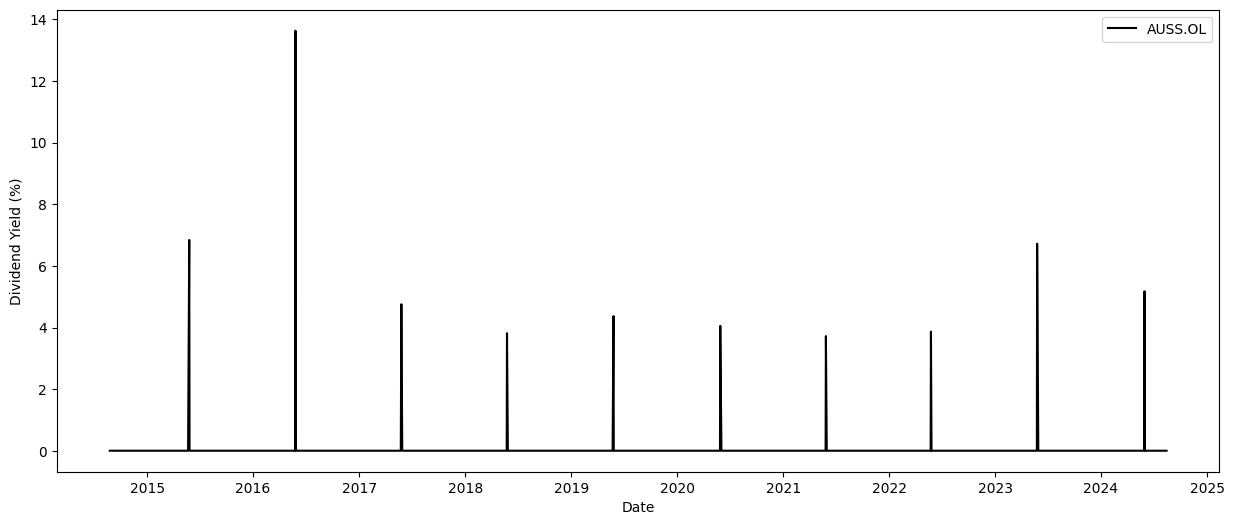

In [16]:
# get share prices and dividend yield data
ticker_all_price = utils.get_historical_share_dividend(share_name, merged_nat_curr)

currency_rate    0.460805
share_price      1.000000
Name: share_price, dtype: float64


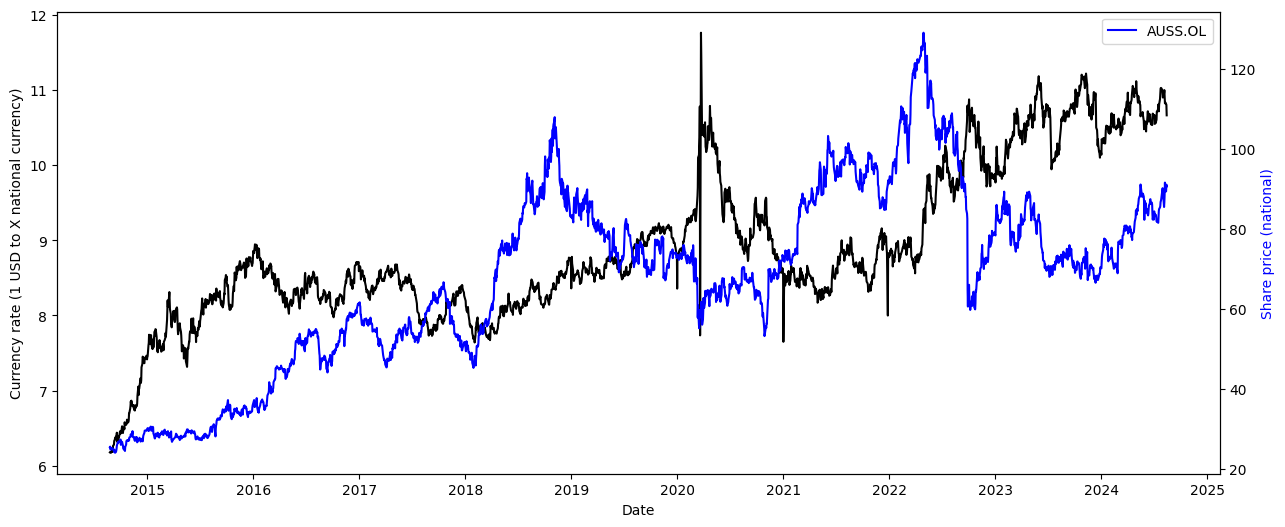

In [17]:
# Pearson's correlation coefficient between share price and USD - national currency rate
utils.get_currency_share_price_correlation(share_name, usd_nat_curr, ticker_all_price)

# Share price and value ratios

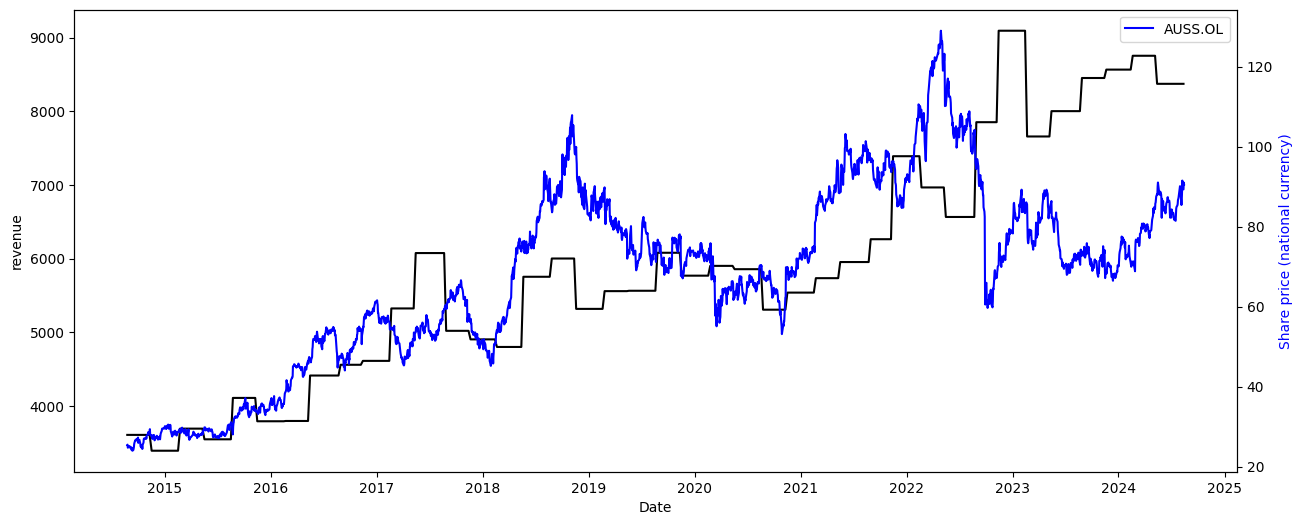

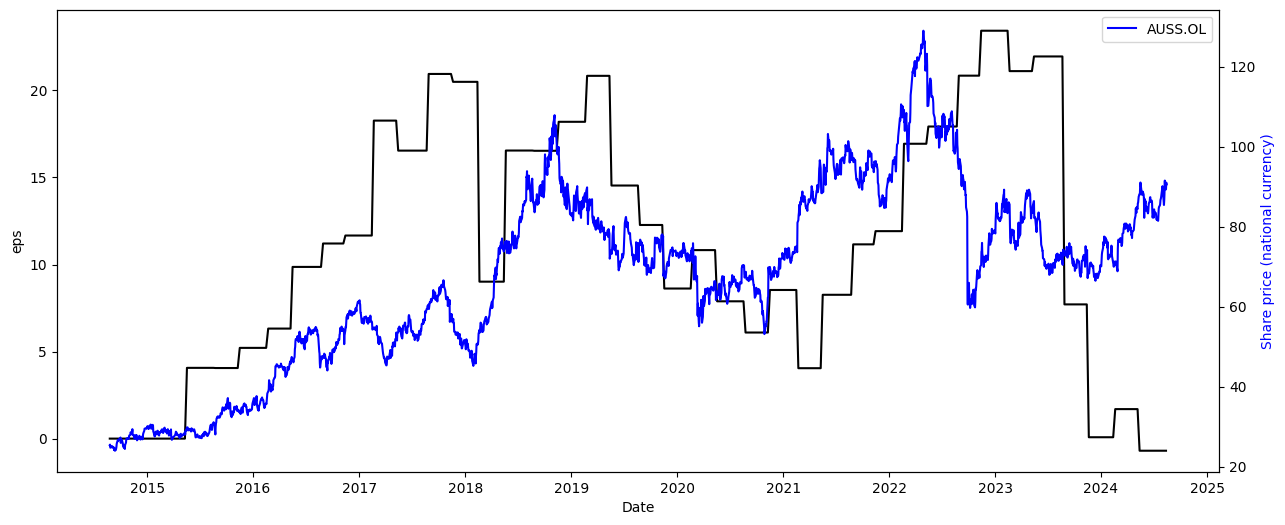

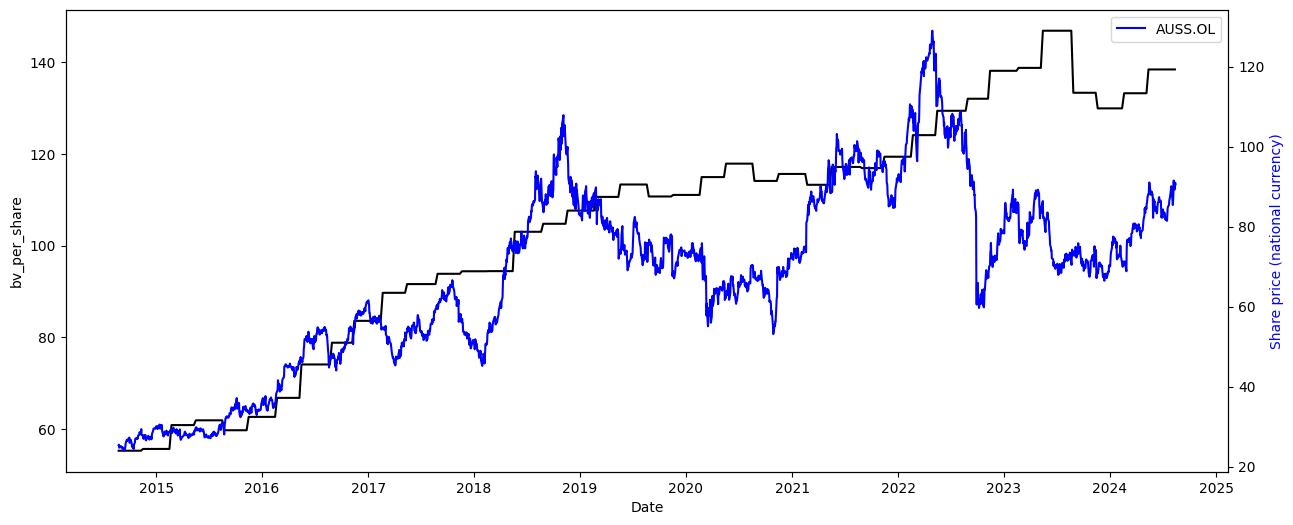

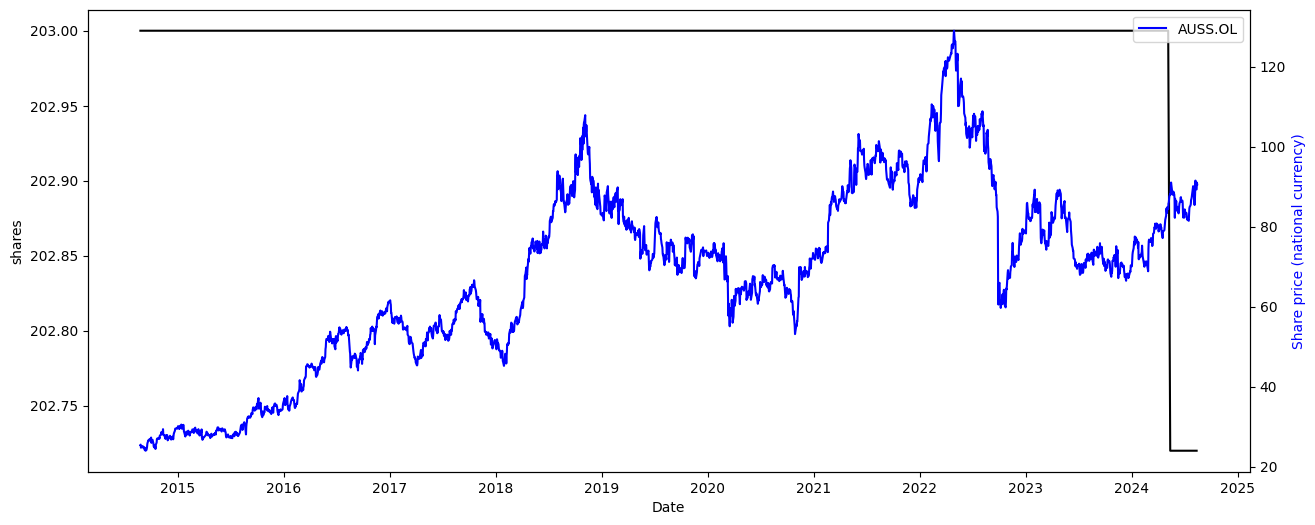

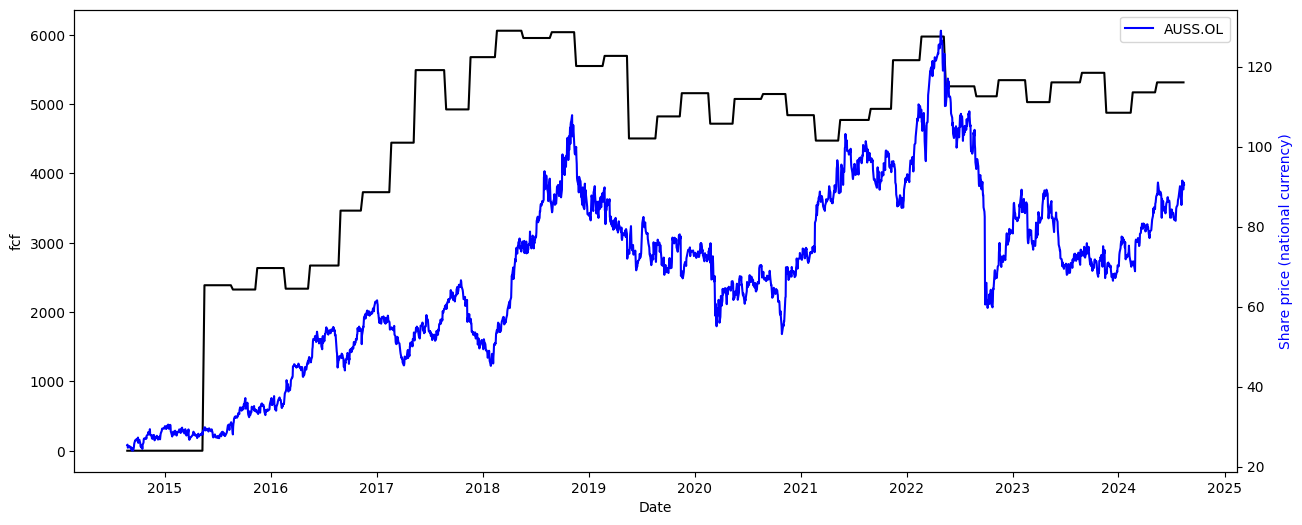

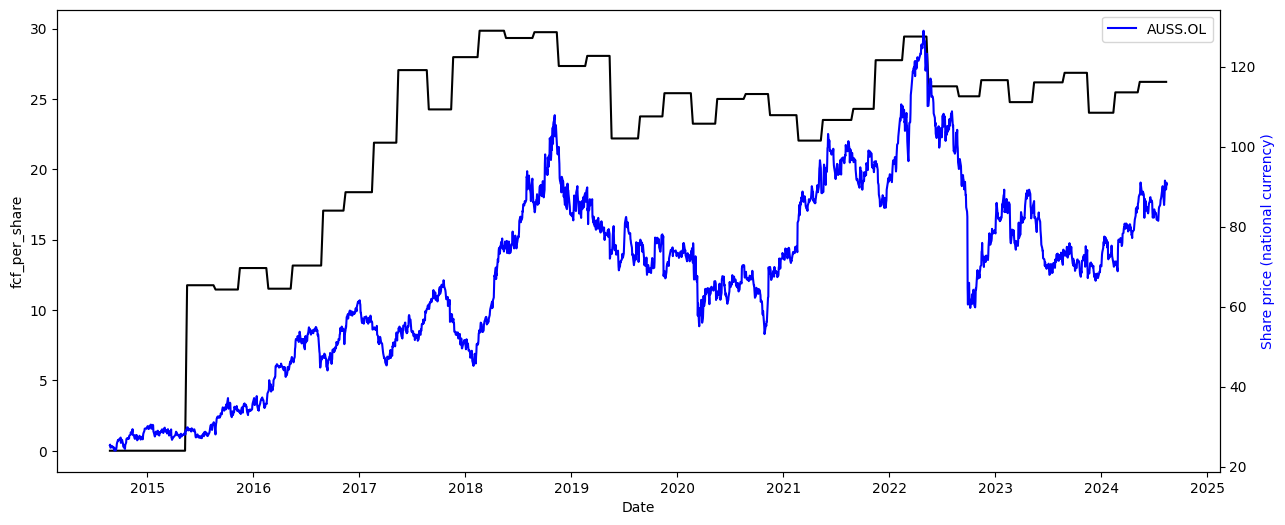

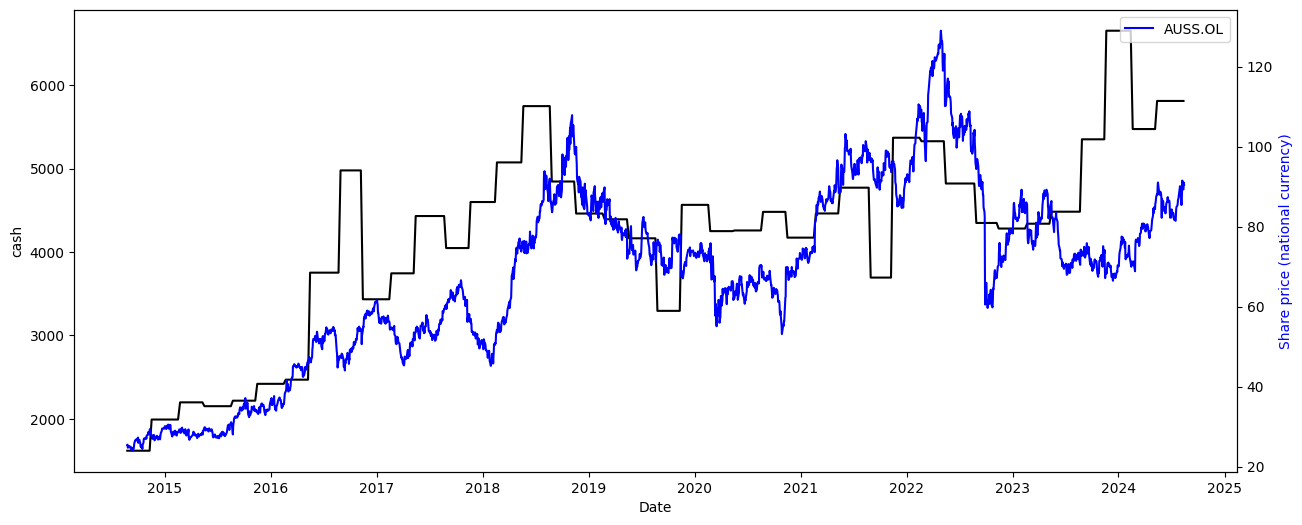

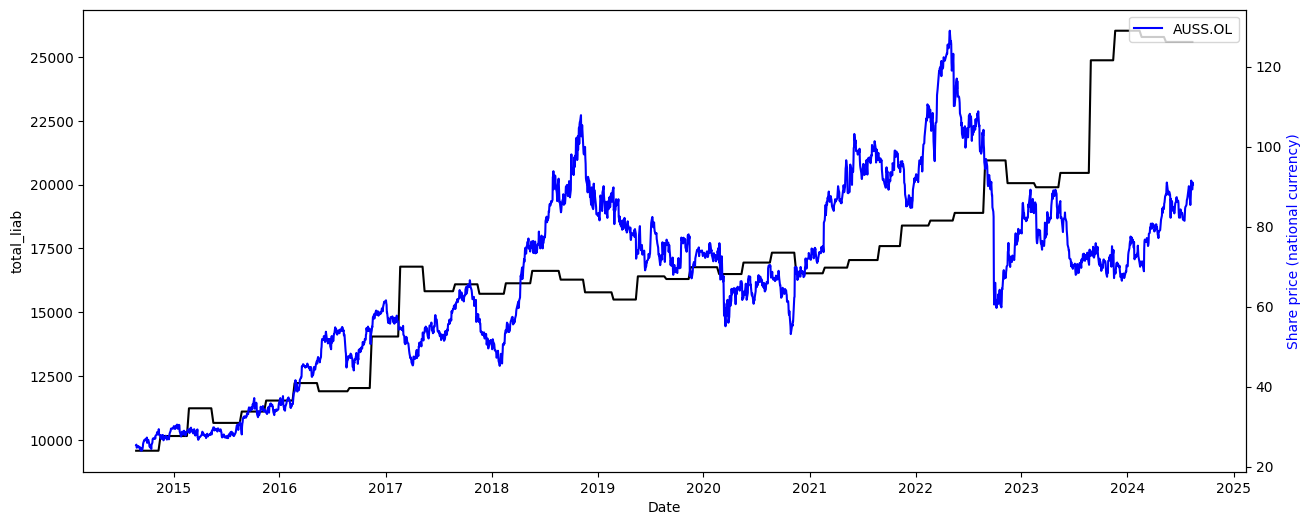

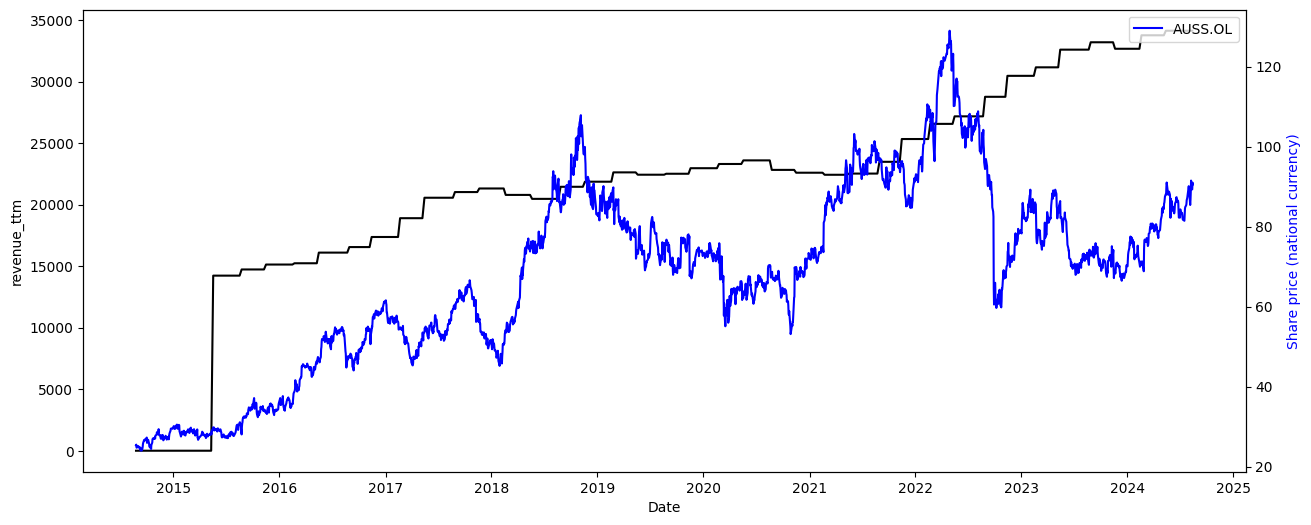

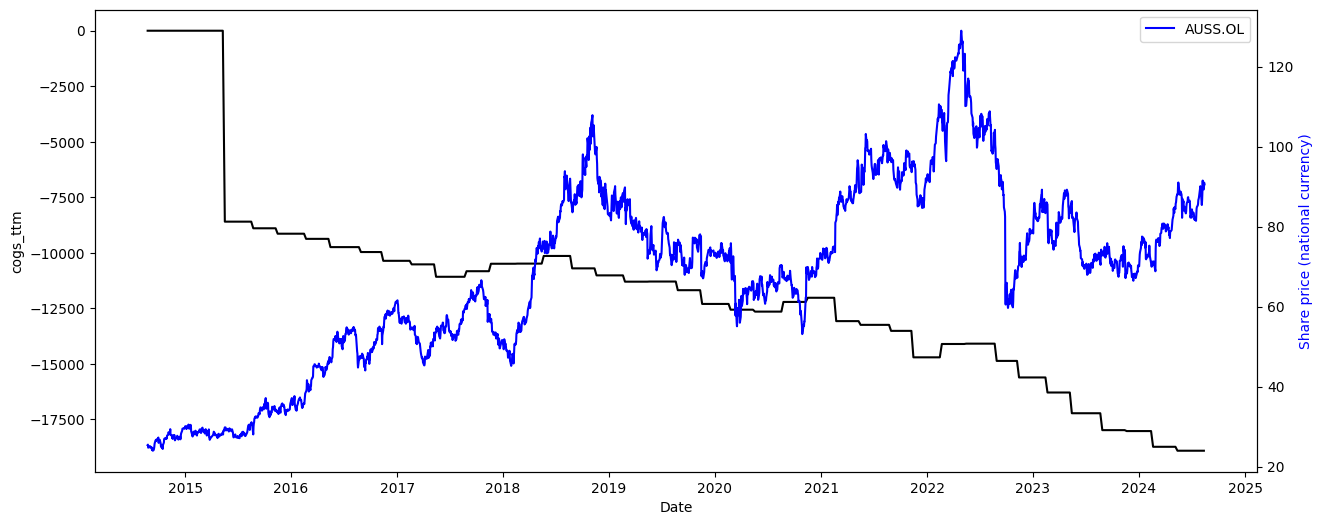

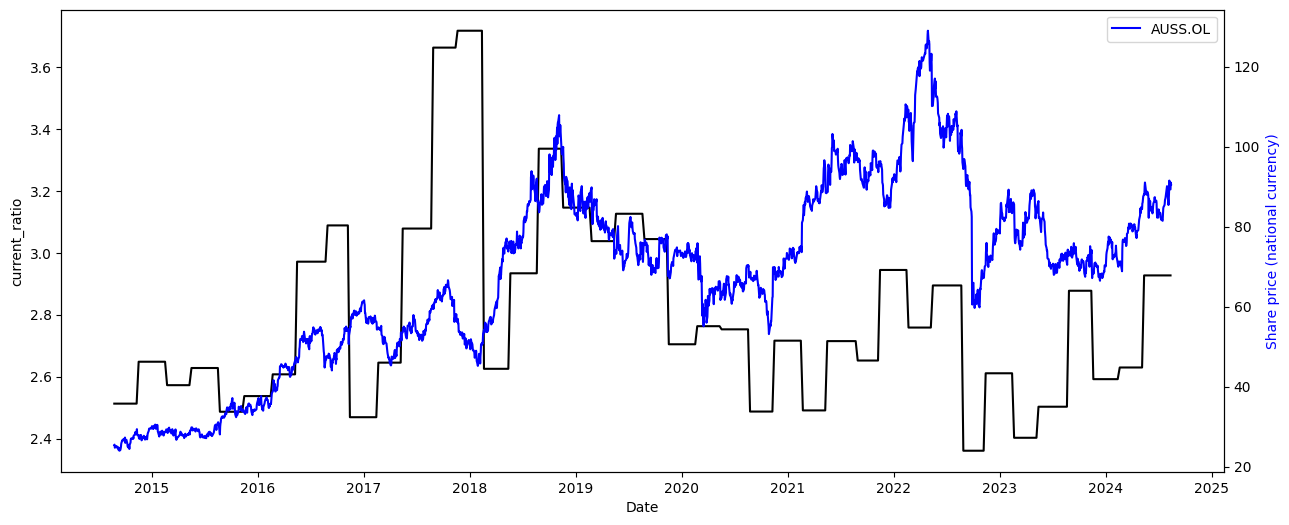

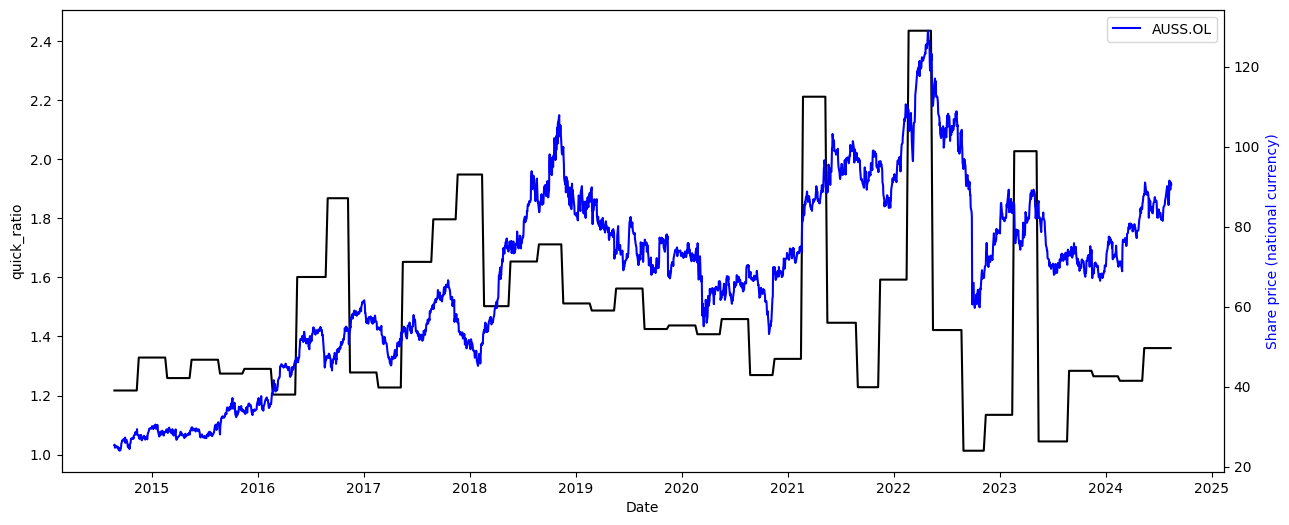

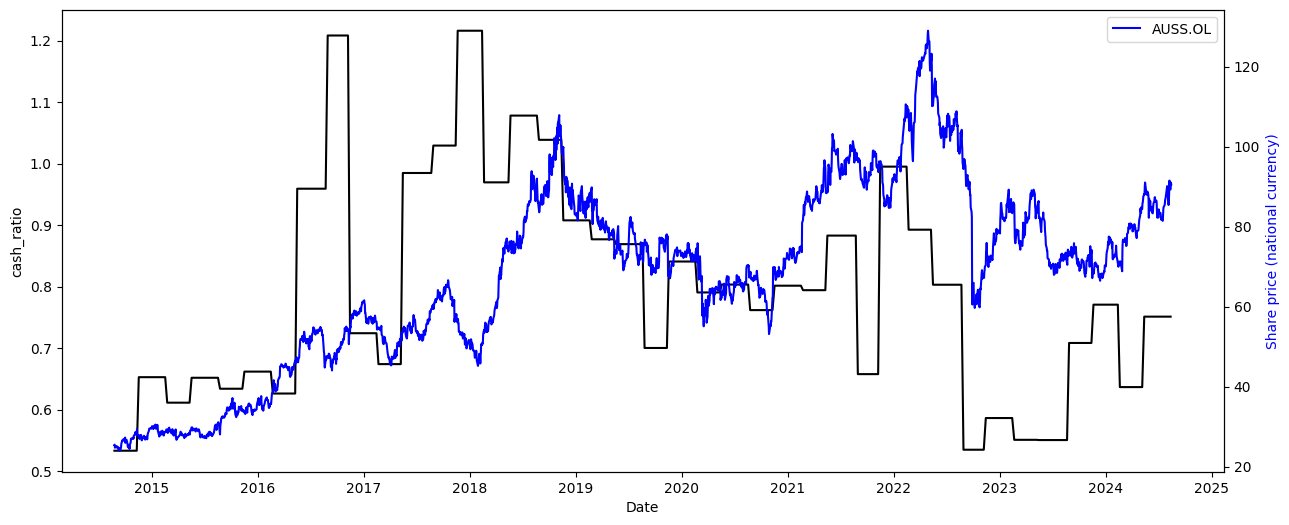

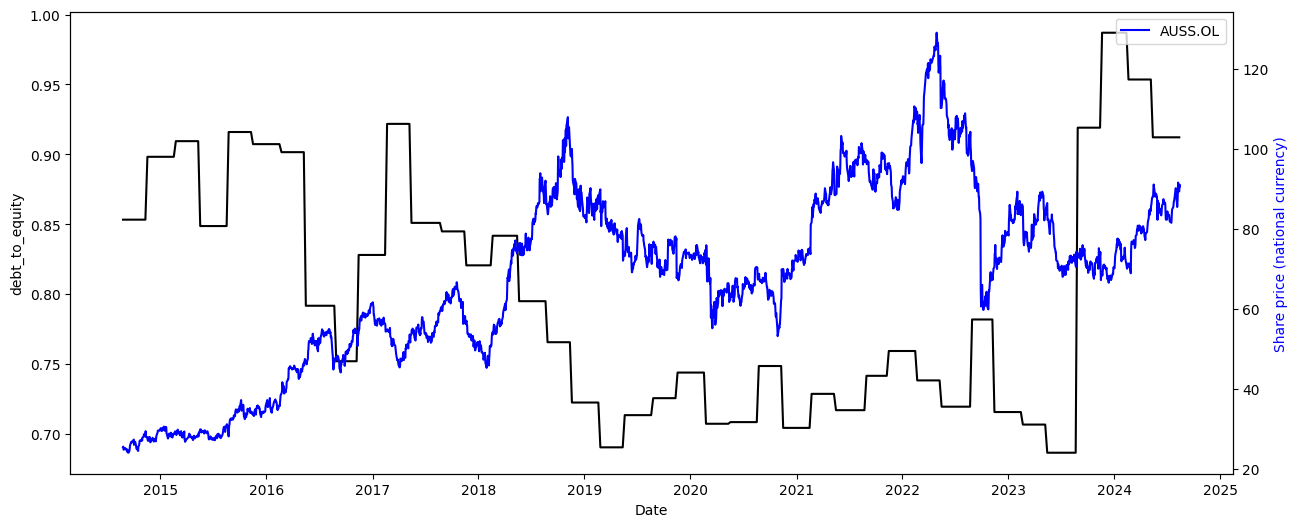

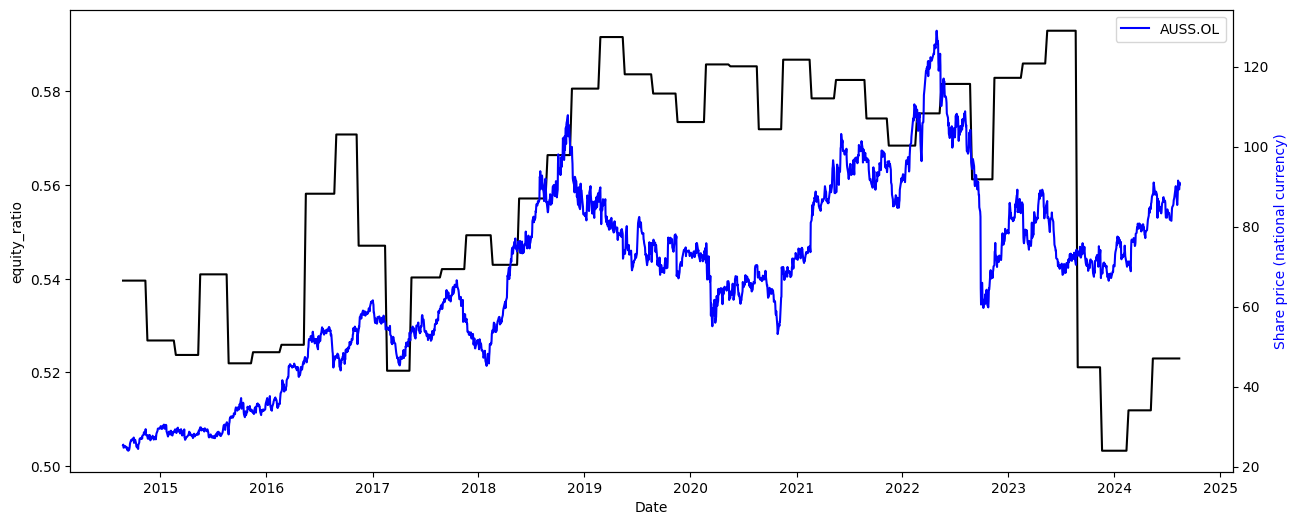

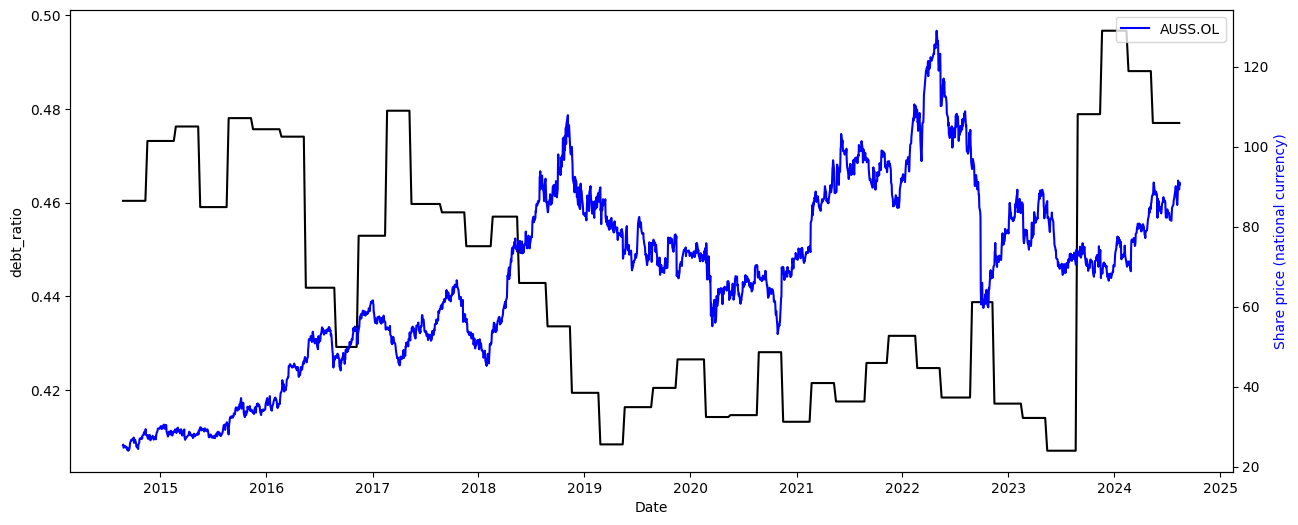

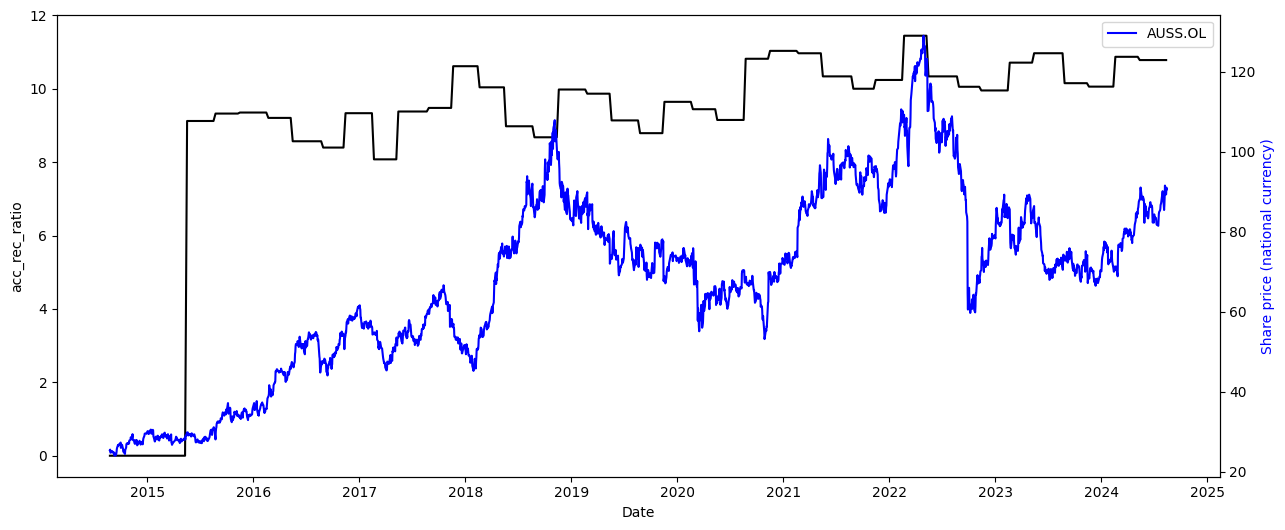

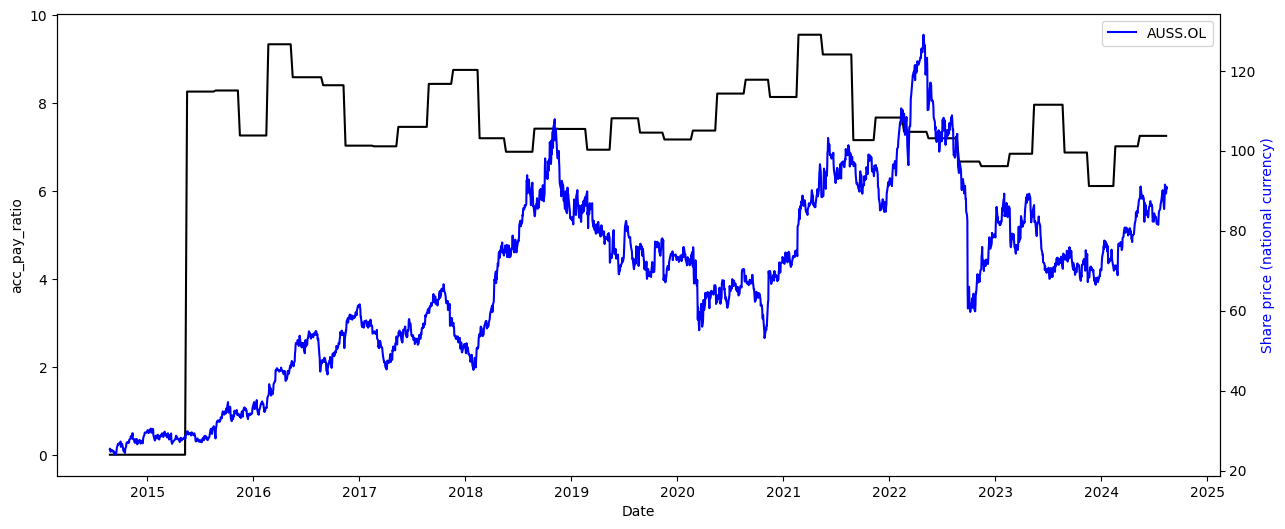

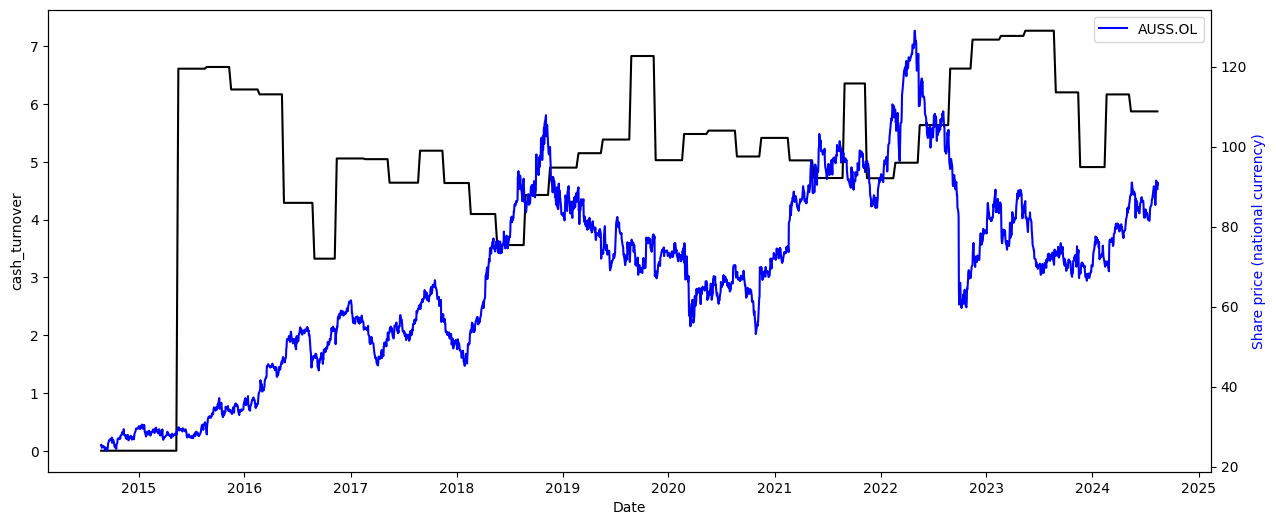

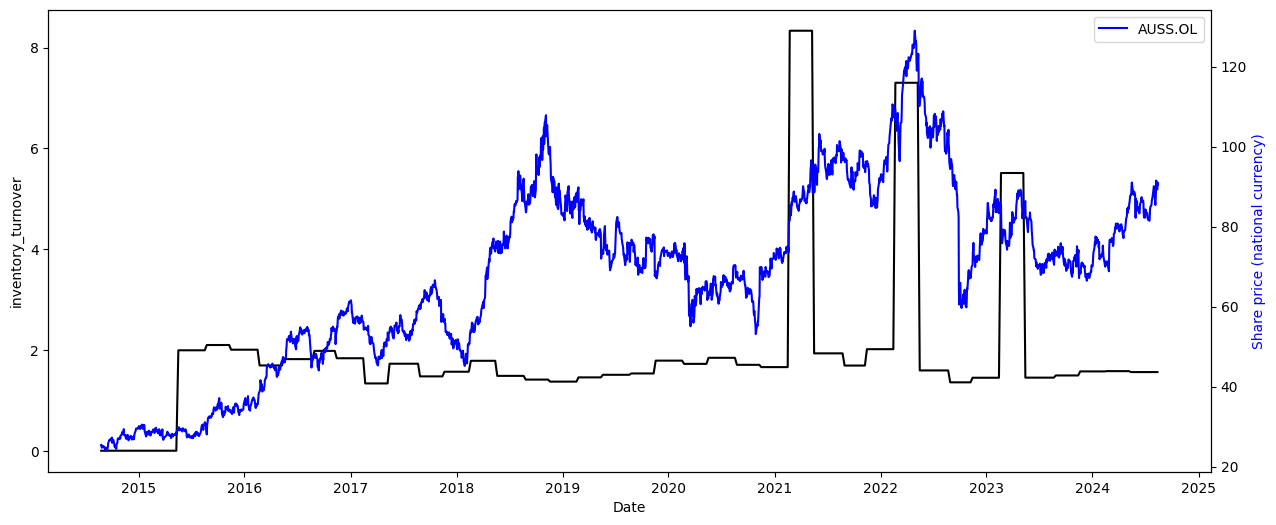

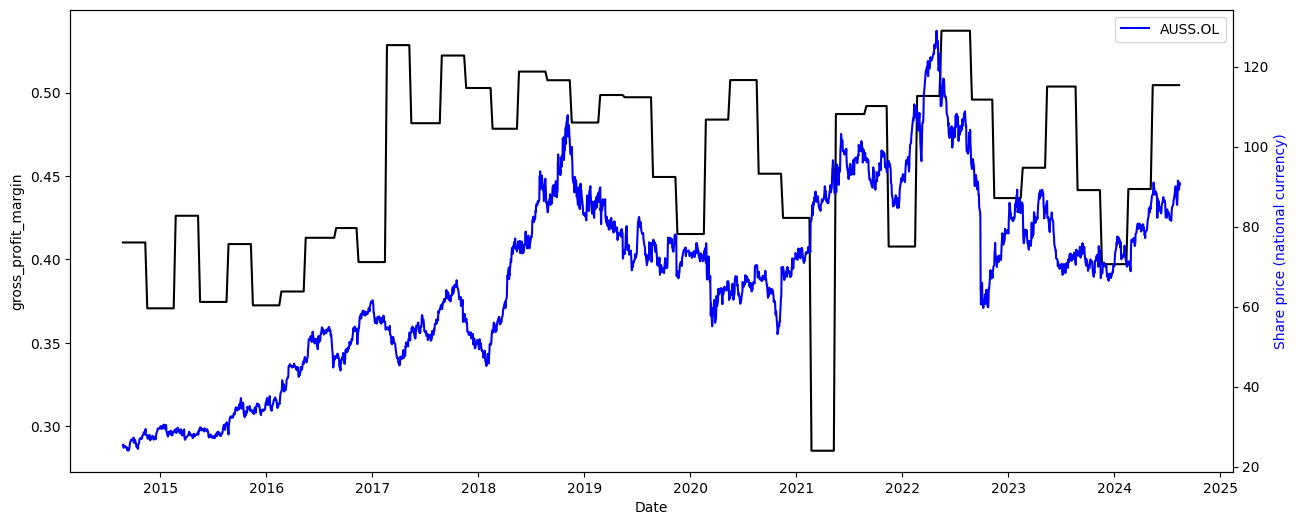

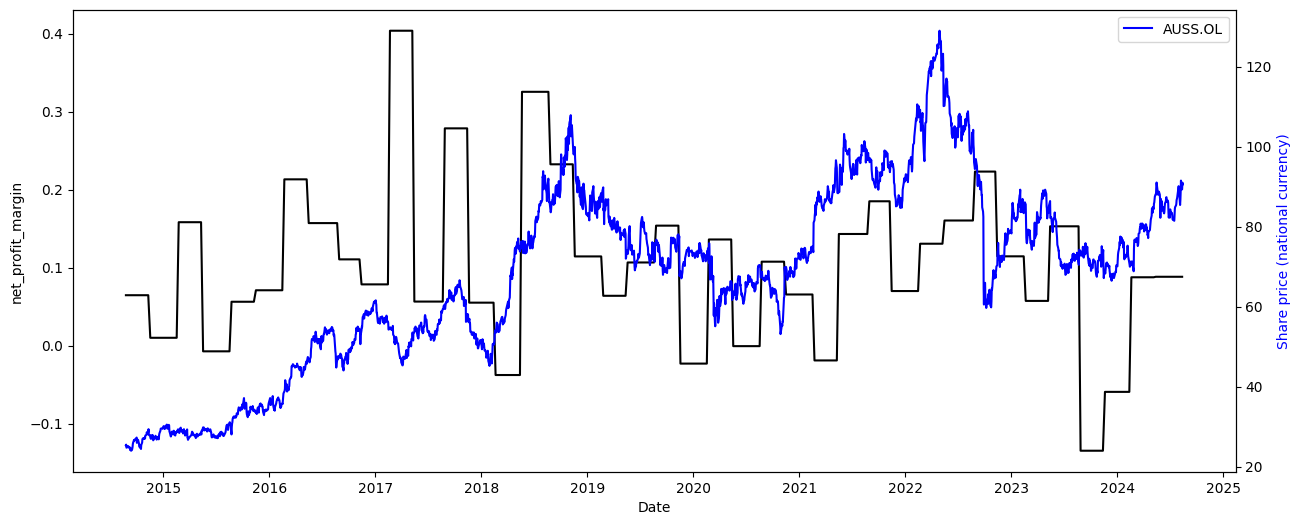

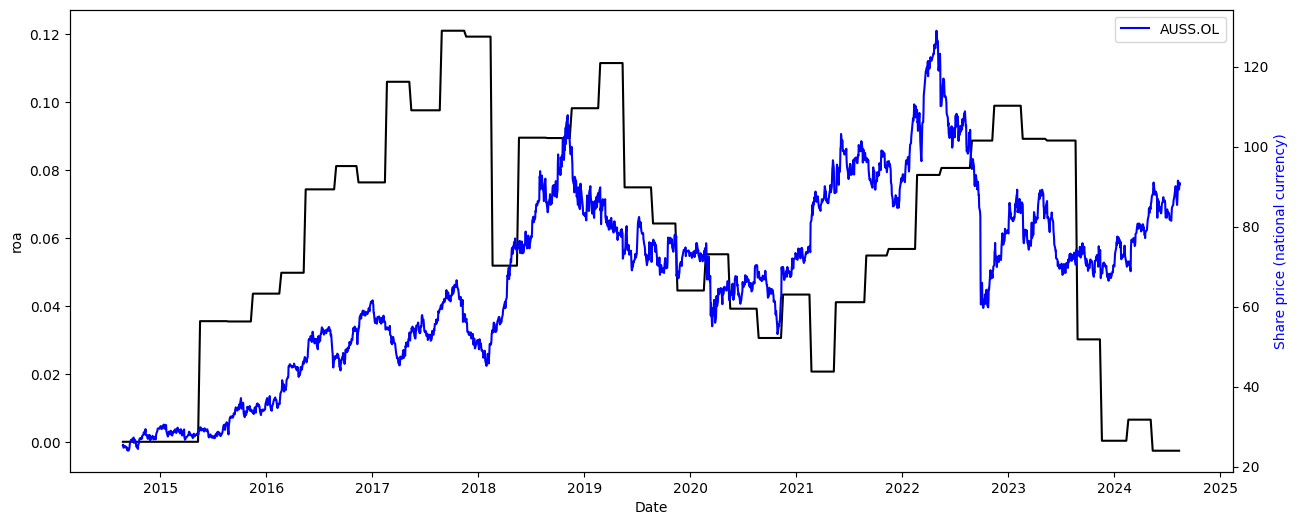

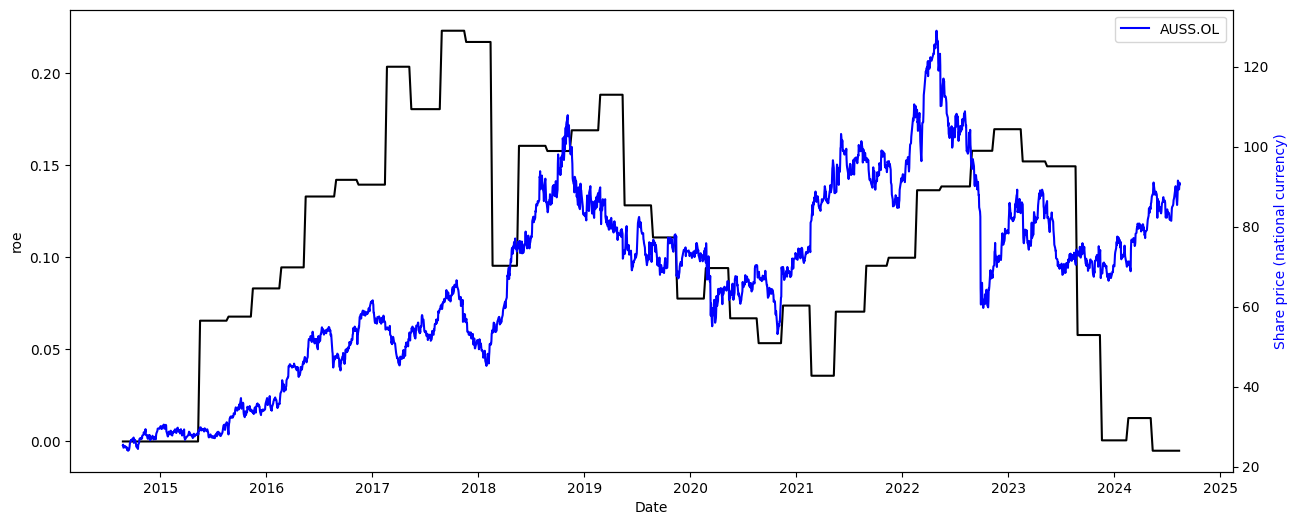

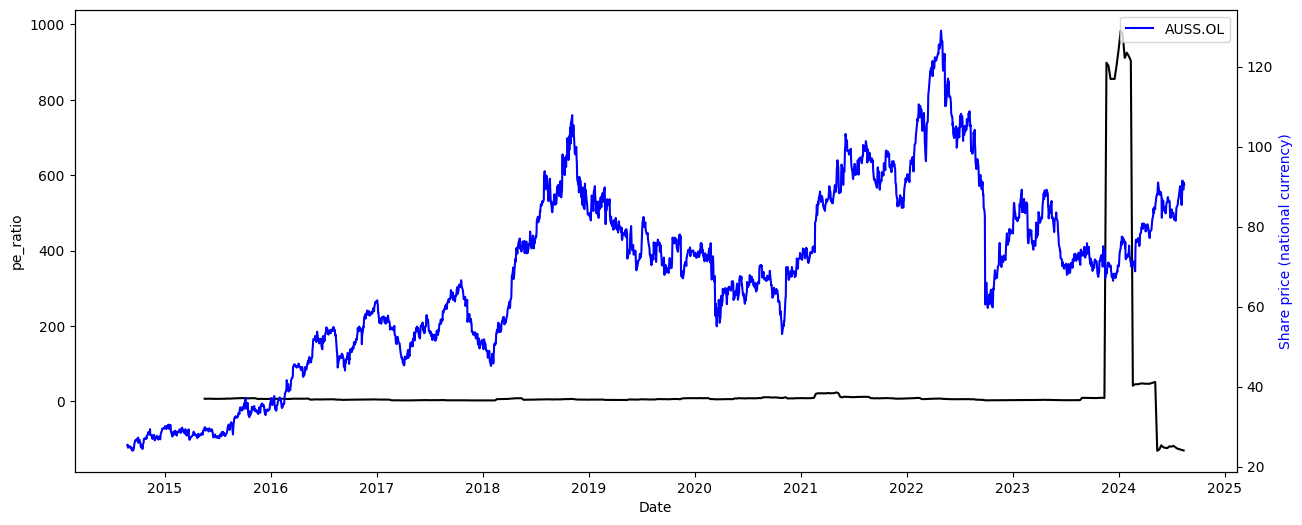

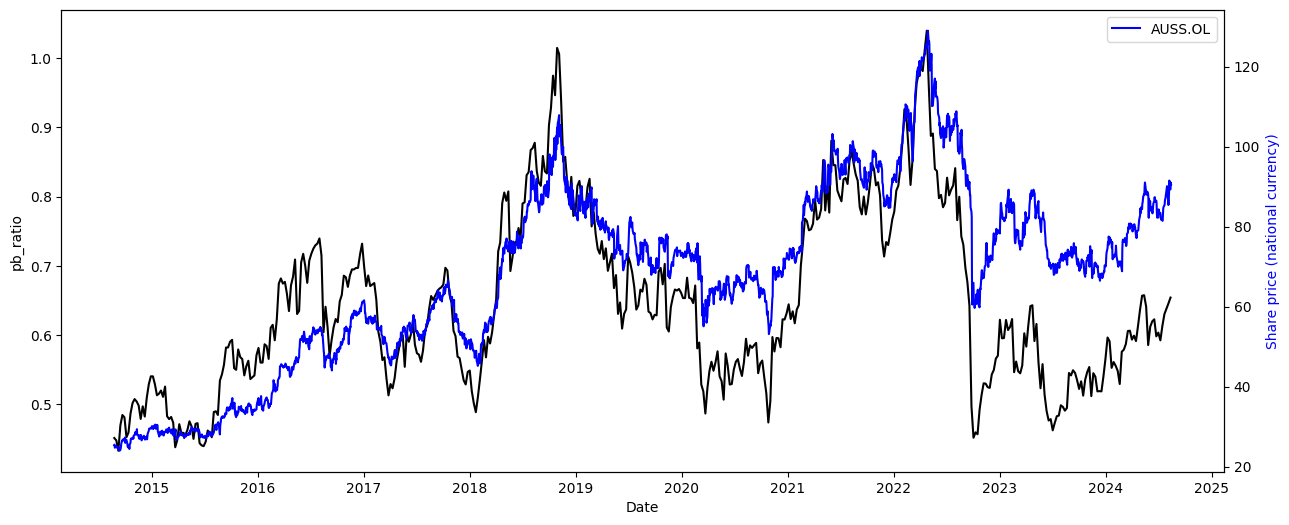

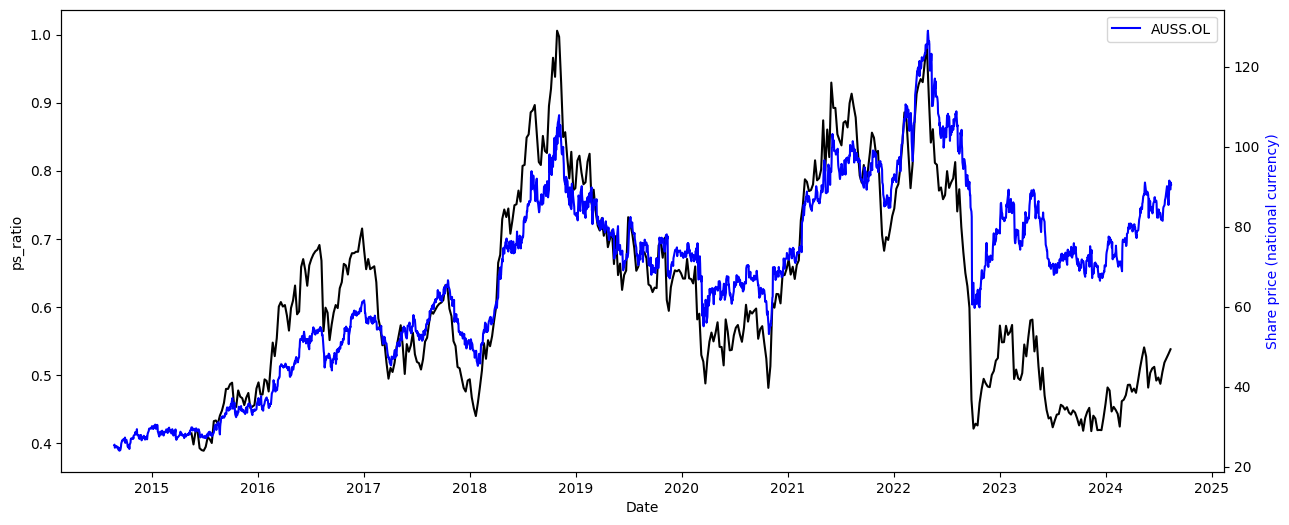

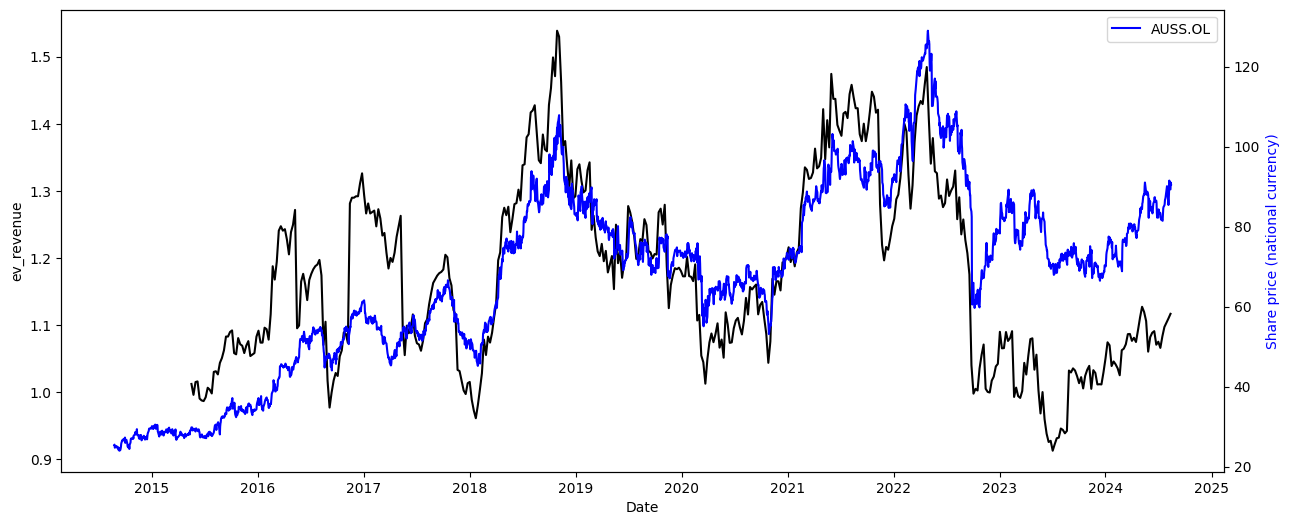

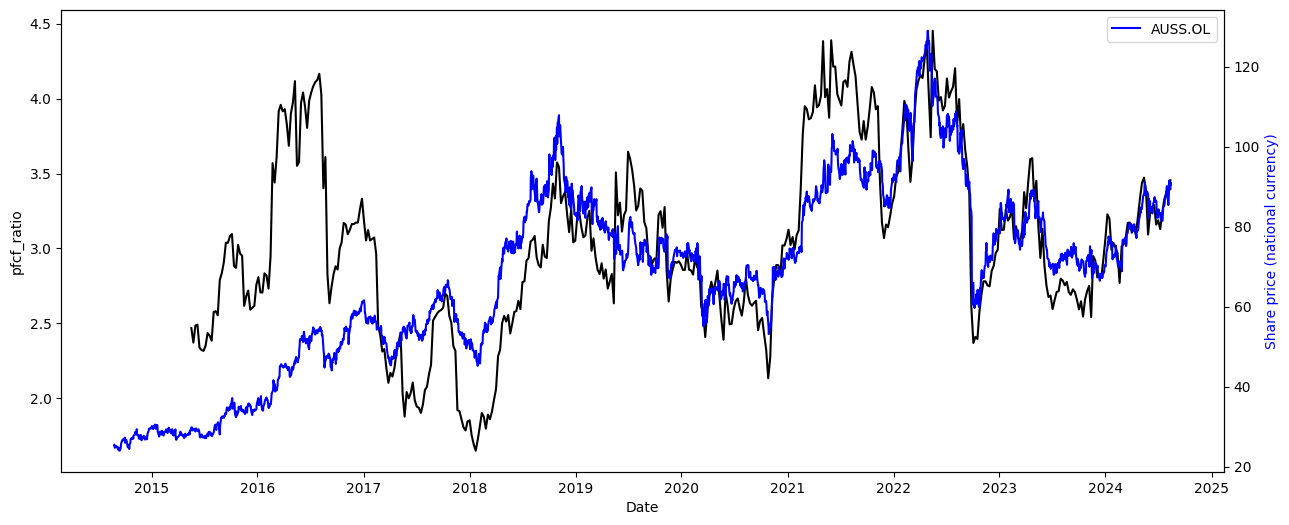

In [18]:
for column in merged_nat_curr.columns[3:]:
    fig, ax1 = plt.subplots(figsize=(15, 6))

    ax2 = ax1.twinx()
    ax1.plot(merged_nat_curr['real_date'], merged_nat_curr[column], color='k', label=merged_nat_curr)
    ax2.plot(ticker_all_price.index, ticker_all_price['Close'], color='b', label=share_name)

    ax1.set_xlabel('Date')
    ax1.set_ylabel(column, color='k')
    ax2.set_ylabel('Share price (national currency)', color='b')

    plt.legend()
    plt.show()

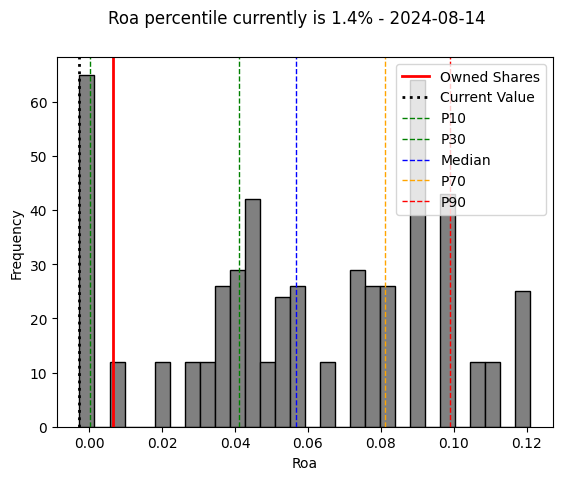

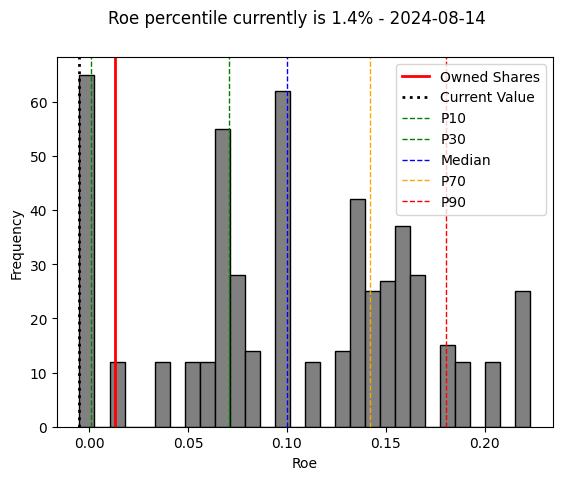

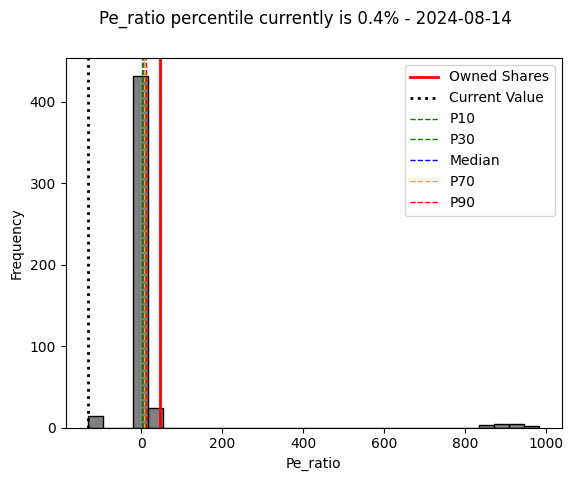

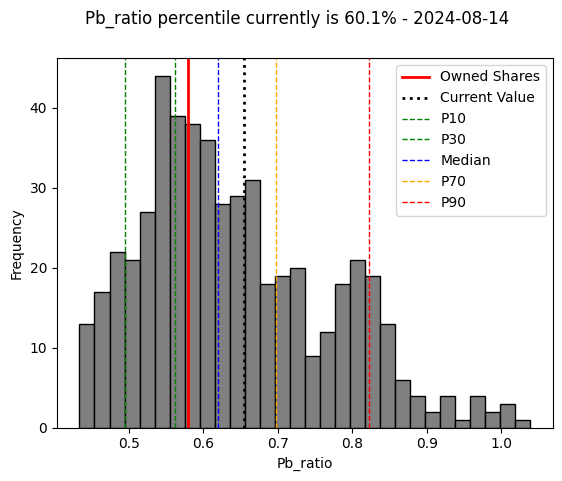

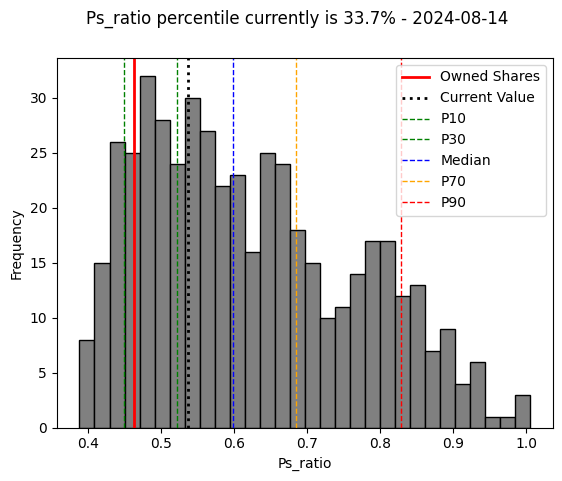

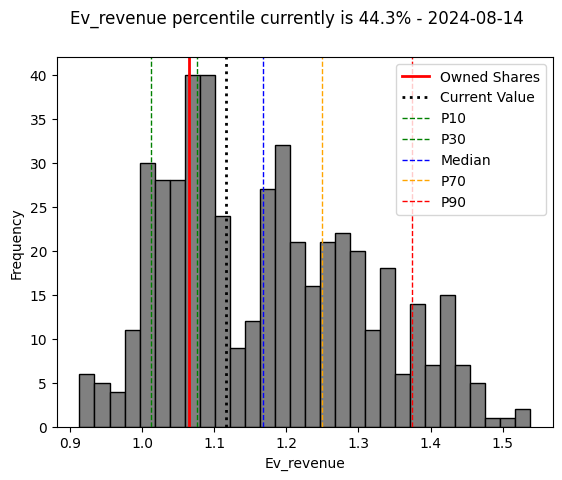

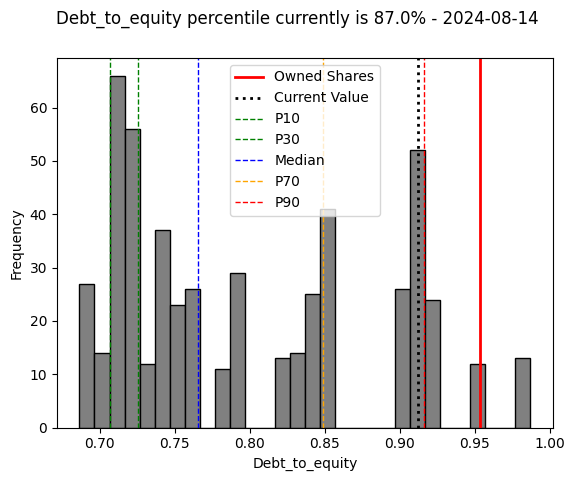

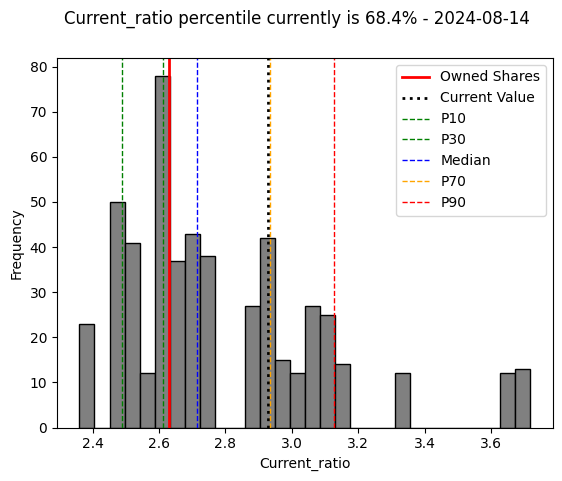

In [19]:
# plot histograms of value parameters
utils.plot_histogram_value_parameters(input_df=merged_nat_curr, extra_parameters=[], owned_shares=owned_shares)

## Calculate correlation between value parameters

In [20]:
# calulate value parameters Pearson's correlation coefficient
pd.DataFrame(merged_nat_curr, columns=['roa', 'roe', 'pe_ratio', 'pb_ratio', 'ps_ratio', 'ev_revenue', 'debt_to_equity', 'current_ratio']).corr()

,roa,roe,pe_ratio,pb_ratio,ps_ratio,ev_revenue,debt_to_equity,current_ratio
roa,1.000000,0.997115,-0.297349,0.300406,0.215066,0.110557,-0.454562,0.507625
roe,0.997115,1.000000,-0.295740,0.283300,0.188121,0.103221,-0.398388,0.513098
pe_ratio,-0.297349,-0.295740,1.000000,-0.130601,-0.183105,-0.144808,0.354040,-0.136684
pb_ratio,0.300406,0.283300,-0.130601,1.000000,0.962789,0.920976,-0.390302,0.281786
ps_ratio,0.215066,0.188121,-0.183105,0.962789,1.000000,0.944023,-0.500264,0.218393
ev_revenue,0.110557,0.103221,-0.144808,0.920976,0.944023,1.000000,-0.288238,0.129818
debt_to_equity,-0.454562,-0.398388,0.354040,-0.390302,-0.500264,-0.288238,1.000000,-0.116878
current_ratio,0.507625,0.513098,-0.136684,0.281786,0.218393,0.129818,-0.116878,1.000000


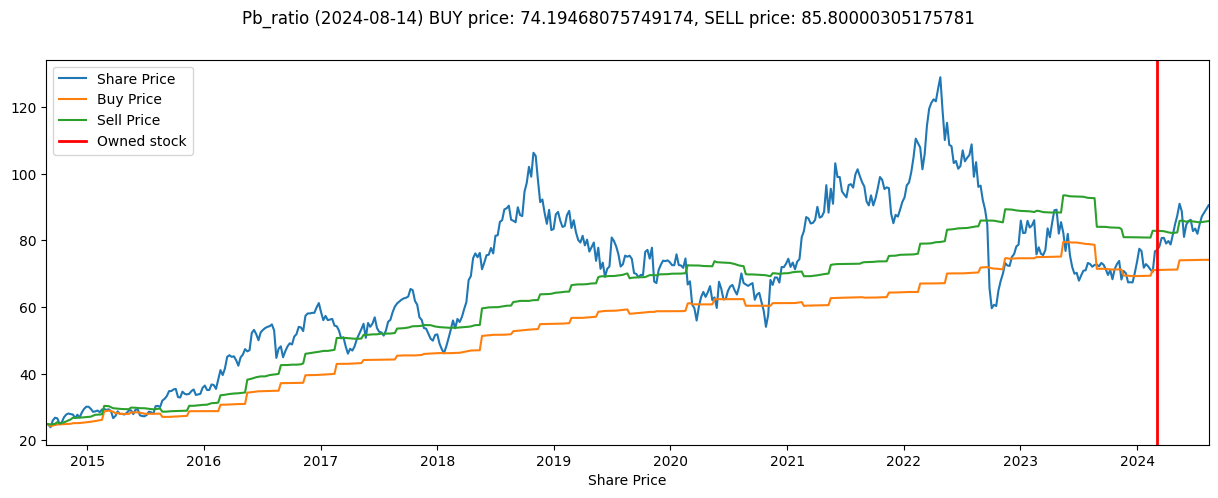

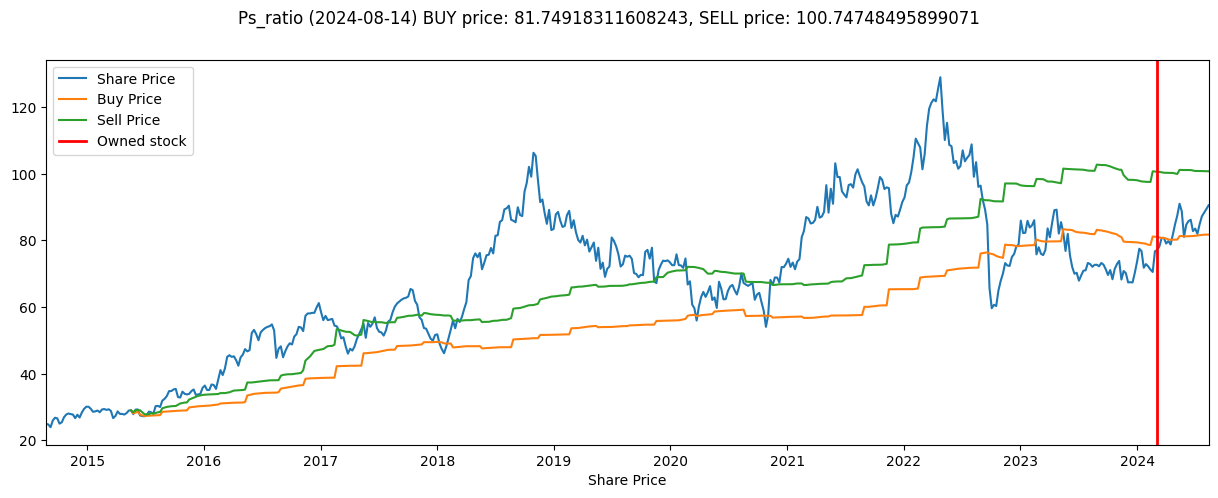

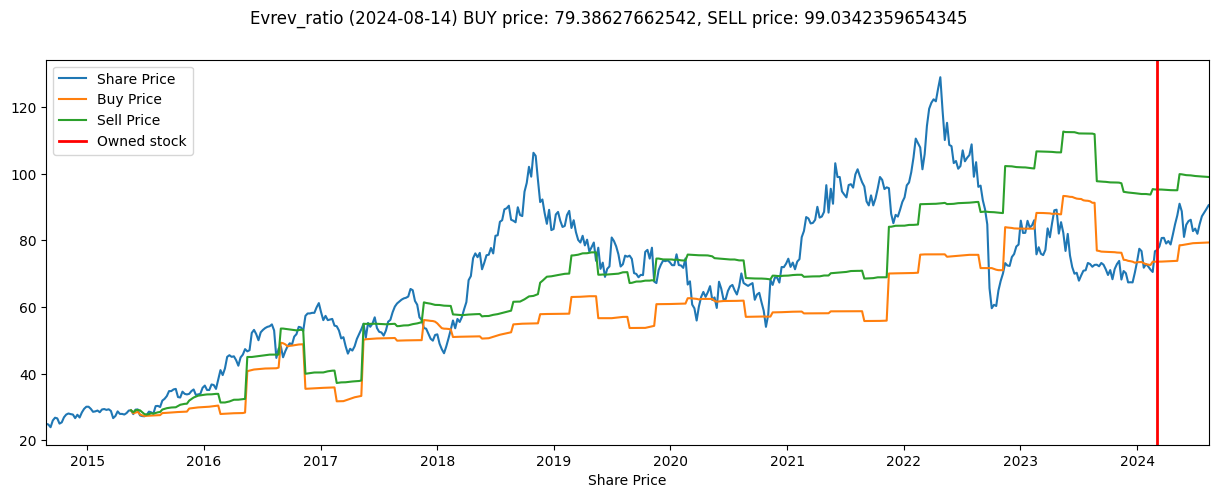

In [21]:
final_df = utils.get_value_stock_target_prices(
    input_df=merged_nat_curr,
    min_pct=0.2,
    max_pct=0.5,
    owned_shares=owned_shares
)